# 1. Giới thiệu về mạng neuron tích chập CNN


#2. Ví dụ minh họa về SRCNN (Super-Resolution Convolutional Neural Network) cải thiện chất lượng hình ảnh bằng các tăng độ phân giải


## 2.1. Import các thư viện cần thiết


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Input
from tensorflow.keras.models import Sequential, Model
import cv2
import numpy as np
import os
import pandas as pd
import random
import matplotlib.pyplot as plt

## 2.2. Chuẩn bị dữ liệu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/DIV2K/hr

/content/drive/MyDrive/ColabNotebooks/DIV2K/hr


In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip

--2024-04-29 08:07:37--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2024-04-29 08:07:37--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  71.8MB/s    in 48s     

2024-04-29 08:08:25 (70.6 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]

--2024-04-29 08:08:26--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip
Resolving data.vision.ee.ethz.ch

In [ ]:
!mkdir Train
!unzip -q DIV2K_train_HR.zip -d Train
!mkdir Valid
!unzip -q DIV2K_valid_HR.zip -d Valid

In [ ]:
%cd /content/drive/MyDrive/ColabNotebooks/DIV2K/lr

/content/drive/MyDrive/ColabNotebooks/DIV2K/lr


In [ ]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_x8.zip

--2024-04-29 08:10:17--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip [following]
--2024-04-29 08:10:17--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_LR_x8.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65753171 (63M) [application/zip]
Saving to: ‘DIV2K_train_LR_x8.zip’

DIV2K_train_LR_x8.z 100%[===================>]  62.71M  44.0MB/s    in 1.4s    

2024-04-29 08:10:18 (44.0 MB/s) - ‘DIV2K_train_LR_x8.zip’ saved [65753171/65753171]

--2024-04-29 08:10:18--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_x8.zip
Resolving data.vision

In [ ]:
!mkdir Train
!unzip -q DIV2K_train_LR_x8.zip -d Train
!mkdir Valid
!unzip -q DIV2K_valid_LR_x8.zip -d Valid

In [ ]:
# def crop_subimages(img, size=256, stride=128):
#     h, w, c = img.shape
#     for i in range(0, h - size + 1, stride):
#         for j in range(0, w - size + 1, stride):
#             yield img[i:i+size, j:j+size, :]

def resize_image(img, size):
    return cv2.resize(img, (size, size))

def create_low_res(img, sigma=0.5, downscale=4):
    blurred = cv2.GaussianBlur(img, (7, 7), sigma)
    downscaled = cv2.resize(blurred, (img.shape[1] // downscale, img.shape[0] // downscale), interpolation=cv2.INTER_NEAREST)
    upscaled = cv2.resize(downscaled, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
    return upscaled

def data_generator(high_res_folder, size, stride, downscale_factor, batch_size):
    img_files = os.listdir(high_res_folder)
    indexes = np.arange(len(img_files))
    np.random.shuffle(indexes)  # Xáo trộn dữ liệu ban đầu
    epoch_count = 0  # Biến để theo dõi số lượng epoch
    while True:
        if epoch_count > 0:
            np.random.shuffle(indexes)  # Xáo trộn lại dữ liệu sau mỗi epoch

        batch_low_res = []
        batch_high_res = []

        for _ in range(batch_size):
            img_idx = np.random.choice(indexes)
            img_path = os.path.join(high_res_folder, img_files[img_idx])
            img = cv2.imread(img_path)

            # sub_img = next(crop_subimages(img, size, stride))

            # Resize ảnh về 256x256
            high_res = resize_image(img, size)
            # tạo ảnh lr
            low_res = create_low_res(high_res, downscale=downscale_factor)

            batch_low_res.append(low_res)
            batch_high_res.append(high_res)

        epoch_count += 1  # Tăng số lượng epoch sau mỗi lô được tạo
        yield (np.array(batch_low_res) / 255.0, np.array(batch_high_res) / 255.0)

# Đọc dữ liệu với generator
train_high_res_folder = '/content/drive/MyDrive/ColabNotebooks/DIV2K/hr/Train/DIV2K_train_HR'
valid_high_res_folder = '/content/drive/MyDrive/ColabNotebooks/DIV2K/hr/Valid/DIV2K_valid_HR'
size = 256
stride = 128
downscale_factor = 4
batch_size = 16

train_gen = data_generator(train_high_res_folder, size, stride, downscale_factor, batch_size)
valid_gen = data_generator(valid_high_res_folder, size, stride, downscale_factor, batch_size)

# Tạo dataset với generator và các phép biến đổi
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen, output_signature=(
    tf.TensorSpec(shape=(batch_size, size, size, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(batch_size, size, size, 3), dtype=tf.float32)
))

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, output_signature=(
    tf.TensorSpec(shape=(batch_size, size, size, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(batch_size, size, size, 3), dtype=tf.float32)
))

train_dataset

<_FlatMapDataset element_spec=(TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(16, 256, 256, 3), dtype=tf.float32, name=None))>

## 2.3. Define SRCNN model

### 2.3.1 Layer 1: Patch extraction and representation


Lớp đầu tiên thực hiện phép tích chập để trích xuất các đặc trưng từ hình ảnh đầu vào có độ phân giải thấp. Quá trình này tương tự như việc lấy mẫu các miếng (patch) nhỏ của hình ảnh và biểu diễn chúng trong một không gian đặc trưng cao hơn.

In [ ]:
# Xây dựng một mô hình nhận diện đặc trưng từ ảnh đầu vào bằng cách sử dụng hai tầng tích chập 2D.
# F1(Y) = max(0, W1 * Y + B1)
def feature_extraction(input_shape):
    model = Sequential([
        Conv2D(64, (9, 9), padding='same', input_shape=input_shape),
        BatchNormalization(axis=3),
        ReLU()
    ])
    return model

### 2.3.2. Layer 2: Non-linear mapping

Lớp thứ hai là một lớp tích chập khác, áp dụng một phép ánh xạ phi tuyến để chuyển đổi các đặc trưng đã được trích xuất từ lớp đầu tiên thành một tập các đặc trưng mới. Quá trình này giúp học các biểu diễn phi tuyến phức tạp hơn của các đặc trưng hình ảnh.

In [ ]:
# F2(Y) = max(0, W2 * F1(Y) + B2)
def non_linear_mapping():
    model = Sequential([
        Conv2D(32, (5, 5), padding='same'),
        BatchNormalization(axis=3),
        ReLU()
    ])
    return model

### 2.3.3. Layer 3: Reconstruction

Lớp cuối cùng là một lớp tích chập nữa, tái tạo lại hình ảnh độ phân giải cao từ các đặc trưng đã được ánh xạ. Lớp này kết hợp các đặc trưng lại với nhau để tạo ra hình ảnh có độ phân giải cao.

In [ ]:
# F(Y) = W3 ∗ F2(Y) + B3
def reconstruction():
     model = Sequential([
        Conv2D(3, (5, 5), padding='same'),
        BatchNormalization(axis=3),
        tf.keras.layers.Activation('linear')
    ])
     return model

### 2.3.4. Model

In [ ]:
def create_srcnn(input_shape):
    input_img = Input(shape=input_shape)

    # Patch extraction and representation
    fe_model = feature_extraction(input_shape)
    fe_output = fe_model(input_img)

    # Non-linear Mapping
    nm_model = non_linear_mapping()
    nm_output = nm_model(fe_output)

    # Reconstruction
    rec_model = reconstruction()
    rec_output = rec_model(nm_output)

    # Create the final SRCNN model
    srcnn_model = Model(inputs=input_img, outputs=rec_output)

    return srcnn_model

In [ ]:
input_shape = (256, 256, 3)
srcnn = create_srcnn(input_shape)
srcnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 64)      15872     
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 32)      51360     
                                                                 
 sequential_2 (Sequential)   (None, 256, 256, 3)       2415      
                                                                 
Total params: 69647 (272.06 KB)
Trainable params: 69449 (271.29 KB)
Non-trainable params: 198 (792.00 Byte)
_________________________________________________________________


## 2.4. Train the model

In [ ]:
early = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/ColabNotebooks/srcnn.keras',save_best_only=True)

In [ ]:
srcnn = create_srcnn((256,256,3))

srcnn.compile(optimizer='adam', loss='mse')

In [ ]:
srcnn.fit(
   train_dataset,
   validation_data=valid_dataset,
   verbose=1,
   epochs=100,
   callbacks=[early, checkpoint],
   steps_per_epoch=100,
   validation_steps=10,
)

Epoch 1/100
100/100 [==============================] - 349s 3s/step - loss: 0.6590 - val_loss: 0.0852
Epoch 2/100
100/100 [==============================] - 198s 2s/step - loss: 0.4717 - val_loss: 0.1072
Epoch 3/100
100/100 [==============================] - 193s 2s/step - loss: 0.3279 - val_loss: 0.1190
Epoch 4/100
100/100 [==============================] - 188s 2s/step - loss: 0.2282 - val_loss: 0.0852
Epoch 5/100
100/100 [==============================] - 186s 2s/step - loss: 0.1585 - val_loss: 0.0686
Epoch 6/100
100/100 [==============================] - 197s 2s/step - loss: 0.1100 - val_loss: 0.0350
Epoch 7/100
100/100 [==============================] - 175s 2s/step - loss: 0.0742 - val_loss: 0.0659
Epoch 8/100
100/100 [==============================] - 195s 2s/step - loss: 0.0534 - val_loss: 0.0273
Epoch 9/100
100/100 [==============================] - 172s 2s/step - loss: 0.0381 - val_loss: 0.0174
Epoch 10/100
100/100 [==============================] - 184s 2s/step - loss: 0.027

## 2.5. Kết quả

<Axes: >

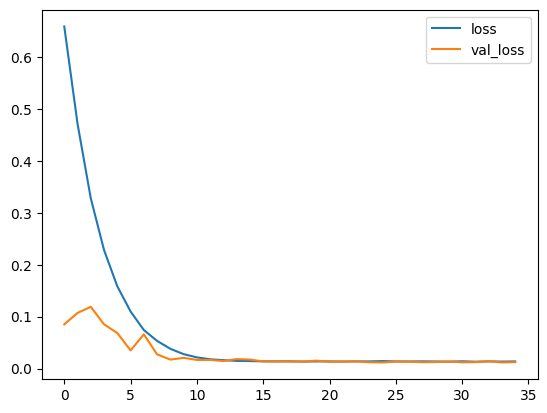

In [ ]:
# vẽ biểu đồ mất mát trong quá trình hội tụ
loss = pd.DataFrame(srcnn.history.history)
loss.plot()

1/1 [==============================] - 0s 102ms/step


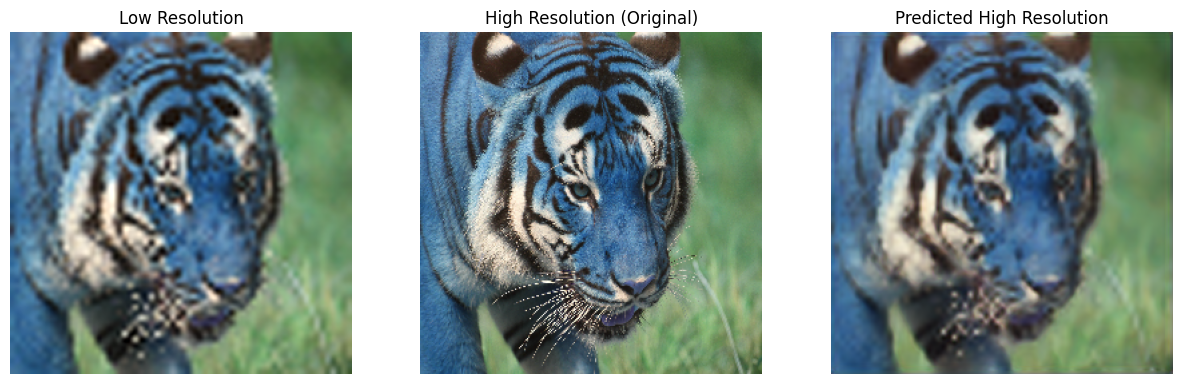

In [ ]:

# Load the best model
model = tf.keras.models.load_model('/content/drive/MyDrive/ColabNotebooks/srcnn.keras')

# Lấy một batch từ train_dataset
for lr, hr in train_dataset.take(1):
    low_res_sample = lr
    high_res_sample = hr


# Dự đoán ảnh chất lượng cao từ ảnh chất lượng thấp
predicted_high_res = model.predict(low_res_sample)

# Hiển thị ảnh chất lượng cao gốc, ảnh chất lượng thấp, và ảnh được dự đoán
plt.figure(figsize=(15, 5))

# Ảnh chất lượng thấp
plt.subplot(1, 3, 1)
plt.title("Low Resolution")
plt.imshow(low_res_sample[0])
plt.axis("off")

# Ảnh chất lượng cao gốc
plt.subplot(1, 3, 2)
plt.title("High Resolution (Original)")
plt.imshow(high_res_sample[0])
plt.axis("off")


# Ảnh được dự đoán
plt.subplot(1, 3, 3)
plt.title("Predicted High Resolution")
plt.imshow(predicted_high_res[0])
plt.axis("off")

plt.show()
